<a href="https://colab.research.google.com/github/kkb0318/benkyokai/blob/main/GaussianProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考：https://docs.pymc.io/pymc-examples/examples/gaussian_processes/GP-Marginal.html

## ライブラリインポート

In [13]:
# !pip install arviz==0.11.0

!pip uninstall theano -y
!pip uninstall theano-pymc -y

Uninstalling Theano-1.0.5:
  Successfully uninstalled Theano-1.0.5


In [14]:
!pip install --upgrade pymc3==3.9.3

Requirement already up-to-date: pymc3==3.9.3 in /usr/local/lib/python3.7/dist-packages (3.9.3)
Processing /root/.cache/pip/wheels/89/40/74/3a0b7d937890c66c4373120117ebf4ba99f4889b4a0a6a810c/Theano-1.0.5-cp37-none-any.whl


In [15]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as st

print(f"Running on PyMC3 v{pm.__version__}")
np.random.seed(seed=10)

Running on PyMC3 v3.9.3


In [16]:
import theano
print(f"Running on PyMC3 v{theano.__version__}")

Running on PyMC3 v1.0.5


In [17]:
plt.rcParams.update(
    {
        "axes.prop_cycle": plt.cycler(
            "color",
            [
                "#000000",
                "#1b6989",
                "#e69f00",
                "#009e73",
                "#f0e442",
                "#50b4e9",
                "#d55e00",
                "#cc79a7",
            ],
        ),
        "figure.figsize": [12.0, 5.0],
        "font.serif": [
            "Palatino",
            "Palatino Linotype",
            "Palatino LT STD",
            "Book Antiqua",
            "Georgia",
            "DejaVu Serif",
        ],
        "font.family": "serif",
        "figure.facecolor": "#fffff8",
        "figure.constrained_layout.use": True,
        "font.size": 14.0,
        "hist.bins": "auto",
        "lines.linewidth": 3.0,
        "lines.markeredgewidth": 2.0,
        "lines.markerfacecolor": "none",
        "lines.markersize": 8.0,
    }
)

## 共分散行列

* ふたつの値がどの程度近い値をとるかの指標

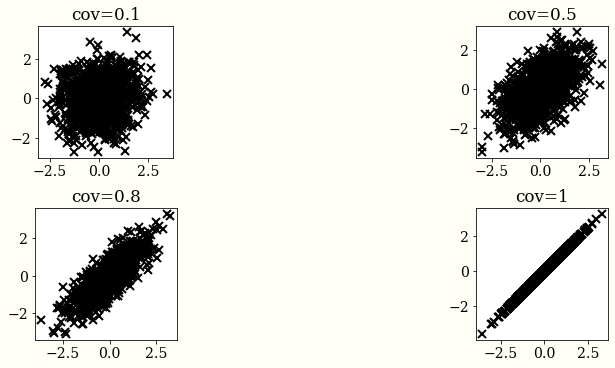

In [18]:
mean = np.array([0, 0])
cov1 = np.array([[1, 0.1],[0.1, 1]])
cov2 = np.array([[1, 0.5],[0.5, 1]])
cov3 = np.array([[1, 0.8],[0.8, 1]])
cov4 = np.array([[1, 1],[1, 1]])

x1, y1 = np.random.multivariate_normal(mean, cov1, 1000).T
x2, y2 = np.random.multivariate_normal(mean, cov2, 1000).T
x3, y3 = np.random.multivariate_normal(mean, cov3, 1000).T
x4, y4 = np.random.multivariate_normal(mean, cov4, 1000).T


fig, axis = plt.subplots(2, 2)

axis[0,0].plot(x1, y1, 'x')
axis[0,0].set_aspect('equal', 'box')
axis[0,0].set_title('cov=0.1')

axis[0,1].plot(x2, y2, 'x')
axis[0,1].set_aspect('equal', 'box')
axis[0,1].set_title('cov=0.5')

axis[1,0].plot(x3, y3, 'x')
axis[1,0].set_aspect('equal', 'box')
axis[1,0].set_title('cov=0.8')

axis[1,1].plot(x4, y4, 'x')
axis[1,1].set_aspect('equal', 'box')
axis[1,1].set_title('cov=1')

plt.show()

### 実装

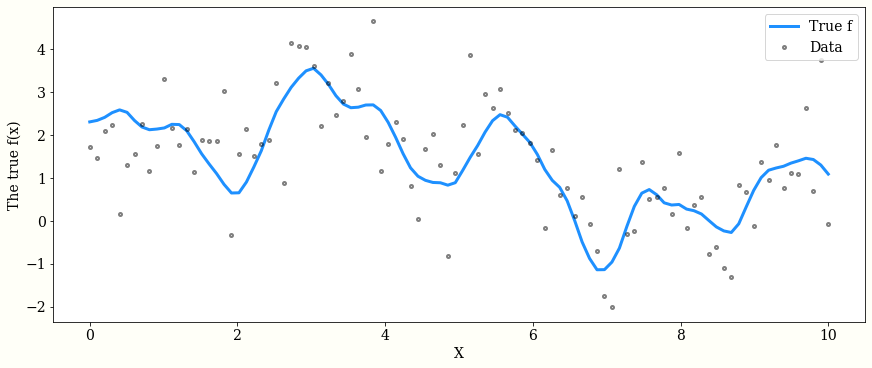

In [19]:
n = 100  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 1.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend();

In [20]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

In [21]:
# new values from x=0 to x=20
X_new = np.linspace(0, 20, 600)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)



In [22]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=500)

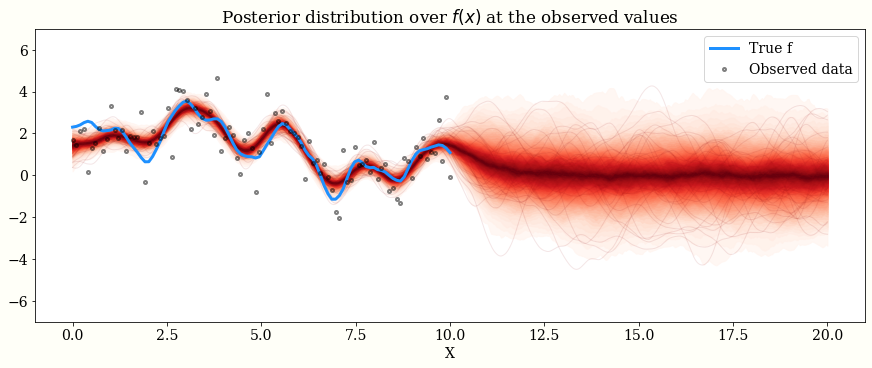

In [25]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X_new)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylim([-7, 7])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();